Problem statement: To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

### Importing Skin Cancer Data
#### To do: Take necessary actions to read the data

### Importing all the important libraries

In [127]:
import pathlib
from glob import glob
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.regularizers import l2

In [128]:
!nvidia-smi

Wed Jun 15 13:47:16 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.103.01   Driver Version: 470.103.01   CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  Off  | 00000000:01:00.0 Off |                  N/A |
| N/A   56C    P3    19W /  N/A |   5838MiB /  6078MiB |      3%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [4]:
## If you are using the data by mounting the google drive, use the following :
## from google.colab import drive
## drive.mount('/content/gdrive')

##Ref:https://towardsdatascience.com/downloading-datasets-into-google-drive-via-google-colab-bcb1b30b0166

This assignment uses a dataset of about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

In [120]:
# Defining the path for train and test images
## Todo: Update the paths of the train and test dataset
data_dir_train = pathlib.Path("Train/")
data_dir_test = pathlib.Path('Test/')

In [121]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

6739
118


### Load using keras.preprocessing

Let's load these images off disk using the helpful image_dataset_from_directory utility.

### Create a dataset

Define some parameters for the loader:

In [122]:
batch_size = 32
img_height = 180
img_width = 180
img_shape = (img_height, img_width, 3)

Use 80% of the images for training, and 20% for validation.

In [9]:
## Write your train dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
train_ds = tf.keras.preprocessing.image_dataset_from_directory("Train/", seed=123, batch_size=batch_size,
                                                               image_size=(img_height, img_width), interpolation="bilinear", 
                                                              validation_split=.2, subset='training')

Found 6741 files belonging to 9 classes.
Using 5393 files for training.


In [10]:
## Write your validation dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
val_ds = tf.keras.preprocessing.image_dataset_from_directory("Train/", seed=123, batch_size=batch_size,
                                                             image_size=(img_height, img_width), interpolation="bilinear",
                                                            validation_split=.2, subset='validation')

Found 6741 files belonging to 9 classes.
Using 1348 files for validation.


In [11]:
# List out all the classes of skin cancer and store them in a list. 
# You can find the class names in the class_names attribute on these datasets. 
# These correspond to the directory names in alphabetical order.
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


In [13]:
for image_batch, labels_batch in train_ds:
    print(image_batch.shape)
    print(labels_batch.shape)
    break

(32, 180, 180, 3)
(32,)


Observations :
 - The Batch size is 32 and the images are loded in 180x180 Size

### Visualize the data
#### Todo, create a code to visualize one instance of all the nine classes present in the dataset

actinic keratosis
basal cell carcinoma
dermatofibroma
melanoma
nevus
pigmented benign keratosis
seborrheic keratosis
squamous cell carcinoma
vascular lesion


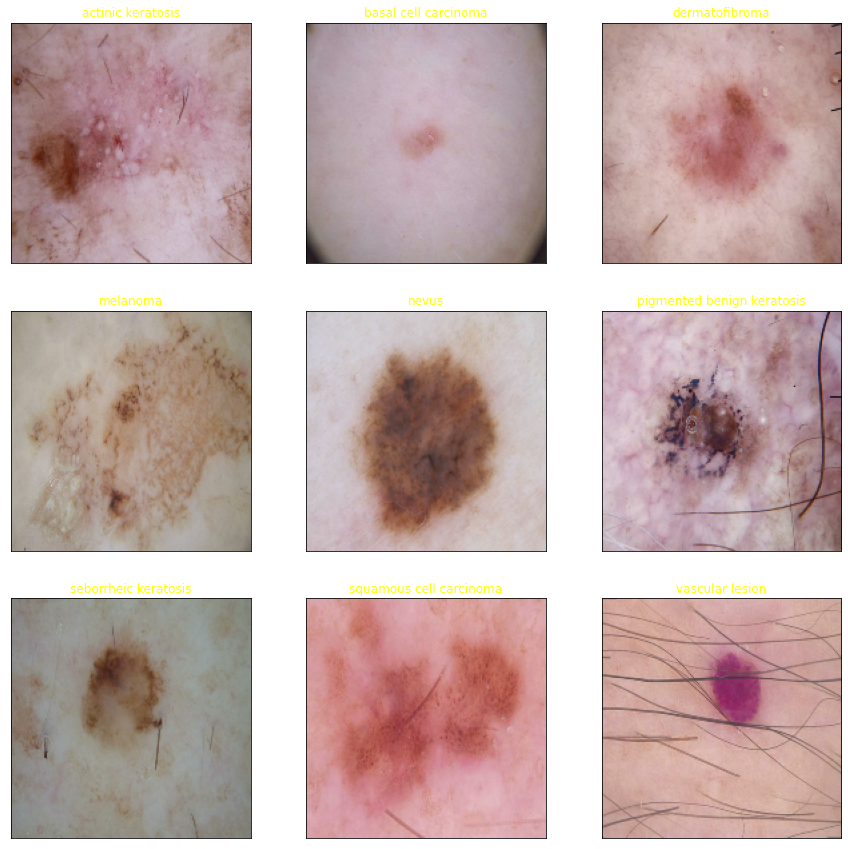

In [14]:
import matplotlib.pyplot as plt
num_classes = len(class_names)
### your code goes here, you can use training or validation data to visualize
plt.figure(figsize=(15,15))

for i in range(len(class_names)):
    for images, classes in train_ds:
        
        idx = np.where(classes==i)[0]
        if len(idx)>0:
            features_idx = images[idx[0]]
            print(class_names[classes[idx[0]]])
            break

    ax = plt.subplot(3, 3, 1+i, xticks=[], yticks=[])
    plt.imshow(features_idx.numpy().astype("uint8"))
    ax.set_title(class_names[i], color='yellow')

The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

In [16]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Create the model
#### Todo: Create a CNN model, which can accurately detect 9 classes present in the dataset. Use ```layers.experimental.preprocessing.Rescaling``` to normalize pixel values between (0,1). The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network. Here, it is good to standardize values to be in the `[0, 1]`

In [100]:
### Your code goes here
model = Sequential([
    layers.experimental.preprocessing.Rescaling(1./255, input_shape=img_shape),
    Conv2D(16, (3, 3), padding='same', activation='relu'),
#     MaxPooling2D(pool_size=(2, 2)),
    Conv2D(32, (3, 3), padding='same', activation='relu'),
    Conv2D(64, (3, 3), padding='same', activation='relu'),
#     MaxPooling2D(pool_size=(2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dense(num_classes, activation='softmax'),
])

### Compile the model
Choose an appropirate optimiser and loss function for model training 

In [19]:
### Todo, choose an appropirate optimiser and loss function
model.compile(optimizer='sgd',
#               loss='categorical_crossentropy',
              loss = 'sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [20]:
# View the summary of all layers
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling_1 (Rescaling)      (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 180, 180, 16)      448       
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 180, 180, 32)      4640      
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 180, 180, 64)      18496     
_________________________________________________________________
flatten_1 (Flatten)          (None, 2073600)           0         
_________________________________________________________________
dense_2 (Dense)              (None, 128)               265420928 
_________________________________________________________________
dense_3 (Dense)              (None, 9)                

### Train the model

In [ ]:
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 [==============================] - 14s 254ms/step - loss: 2.0645 - accuracy: 0.2254 - val_loss: 2.0153 - val_accuracy: 0.2998
Epoch 2/20
56/56 [==============================] - 12s 208ms/step - loss: 1.9812 - accuracy: 0.2723 - val_loss: 1.9562 - val_accuracy: 0.2908
Epoch 3/20
56/56 [==============================] - 12s 209ms/step - loss: 1.8790 - accuracy: 0.3387 - val_loss: 2.0374 - val_accuracy: 0.2394
Epoch 4/20
56/56 [==============================] - 12s 209ms/step - loss: 1.8303 - accuracy: 0.3253 - val_loss: 1.7875 - val_accuracy: 0.3356
Epoch 5/20
56/56 [==============================] - 12s 209ms/step - loss: 1.8081 - accuracy: 0.3499 - val_loss: 1.7601 - val_accuracy: 0.3490
Epoch 6/20
56/56 [==============================] - 12s 210ms/step - loss: 1.8342 - accuracy: 0.3315 - val_loss: 1.7978 - val_accuracy: 0.3400
Epoch 7/20
56/56 [==============================] - 12s 209ms/step - loss: 1.7422 - accuracy: 0.3739 - val_loss: 1.7435 - val_accuracy: 0.3378

### Visualizing training results

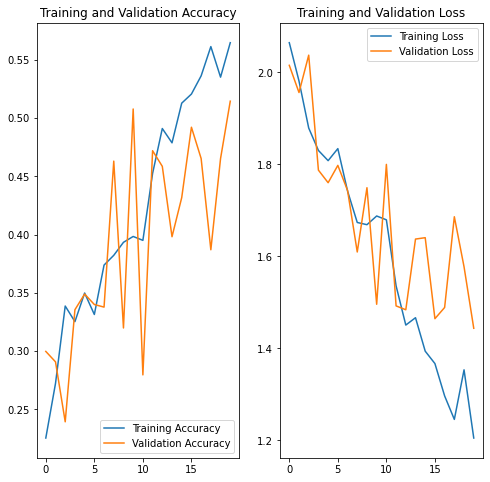

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Todo: Write your findings after the model fit, see if there is an evidence of model overfit or underfit

Observations:
- The Model is showing a poor performance on the train and validation data which indicate both problems of Over-fitting and under-fitting, the model is not generalizing well the classes, lets use the augmentation method to increase the data samples more.

In [23]:
# Todo, after you have analysed the model fit history for presence of underfit or overfit, choose an appropriate data augumentation strategy. 
# Your code goes here
data_aug = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical", input_shape=img_shape),
    layers.experimental.preprocessing.RandomRotation(0.2),
#     layers.experimental.preprocessing,
])

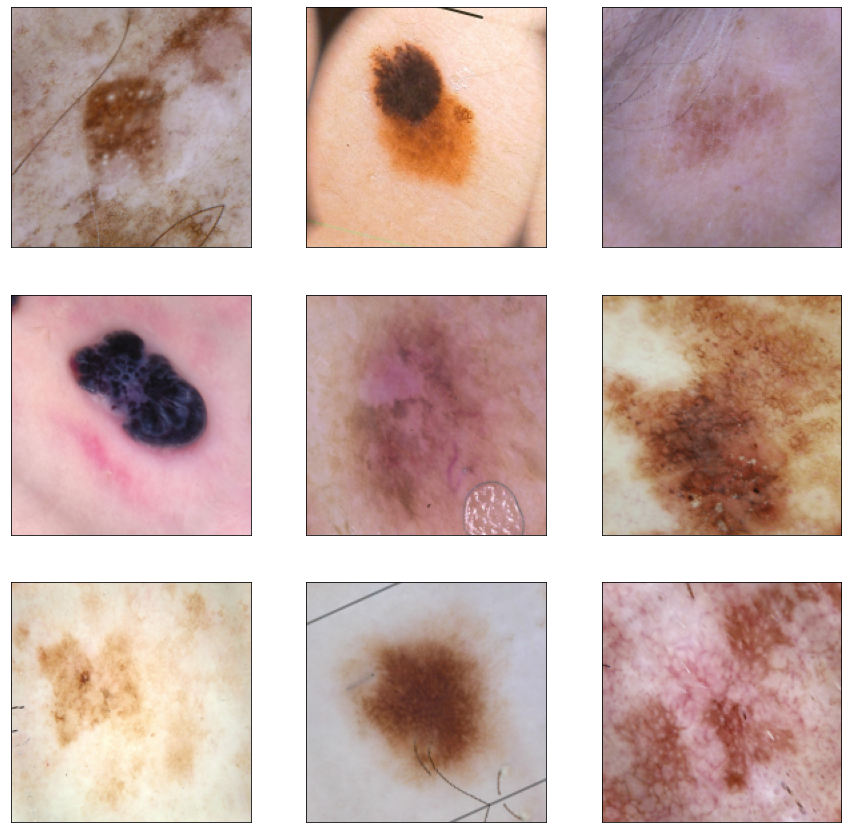

In [25]:
# Todo, visualize how your augmentation strategy works for one instance of training image.
# Your code goes here
        
plt.figure(figsize=(15,15))
for image, clas in train_ds.take(1):
    aug_img = data_aug(image)
        
    for i in range(9):
        ax = plt.subplot(3, 3, i+1, xticks=[], yticks=[])
        plt.imshow(aug_img[i].numpy().astype("uint8"))

### Todo:
### Create the model, compile and train the model


In [ ]:
## You can use Dropout layer if there is an evidence of overfitting in your findings
## Your code goes here

model2 = Sequential([
    data_aug,
    layers.experimental.preprocessing.Rescaling(1./255),
    BatchNormalization(),
    
    Conv2D(16, (3, 3), padding='same', activation='relu'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.25),
    
    Conv2D(32, (3, 3), padding='same', activation='relu'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.25),
    
    Conv2D(64, (3, 3), padding='same', activation='relu'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.25),
    
    Flatten(),
    Dense(128, activation='relu'),
    Dense(num_classes, activation='softmax'),
])

### Compiling the model

In [ ]:
## Your code goes here
model2.compile(optimizer='sgd',
#               loss='categorical_crossentropy',
              loss = 'sparse_categorical_crossentropy',
              metrics=['accuracy'])

model2.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_7 (Sequential)    (None, 180, 180, 3)       0         
_________________________________________________________________
rescaling_6 (Rescaling)      (None, 180, 180, 3)       0         
_________________________________________________________________
batch_normalization_20 (Batc (None, 180, 180, 3)       12        
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 180, 180, 16)      448       
_________________________________________________________________
batch_normalization_21 (Batc (None, 180, 180, 16)      64        
_________________________________________________________________
max_pooling2d_15 (MaxPooling (None, 90, 90, 16)        0         
_________________________________________________________________
dropout_15 (Dropout)         (None, 90, 90, 16)       

### Training the model

In [ ]:
## Your code goes here, note: train your model for 20 epochs
history = model2.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 [==============================] - 3s 50ms/step - loss: 3.8753 - accuracy: 0.2682 - val_loss: 5.6853 - val_accuracy: 0.2058
Epoch 2/20
56/56 [==============================] - 3s 49ms/step - loss: 1.5888 - accuracy: 0.4094 - val_loss: 9.3021 - val_accuracy: 0.2058
Epoch 3/20
56/56 [==============================] - 3s 48ms/step - loss: 1.4141 - accuracy: 0.4767 - val_loss: 10.0474 - val_accuracy: 0.2058
Epoch 4/20
56/56 [==============================] - 3s 47ms/step - loss: 1.4079 - accuracy: 0.4959 - val_loss: 9.4101 - val_accuracy: 0.2058
Epoch 5/20
56/56 [==============================] - 3s 47ms/step - loss: 1.3335 - accuracy: 0.5139 - val_loss: 7.6657 - val_accuracy: 0.2260
Epoch 6/20
56/56 [==============================] - 3s 47ms/step - loss: 1.3344 - accuracy: 0.5418 - val_loss: 6.0804 - val_accuracy: 0.2729
Epoch 7/20
56/56 [==============================] - 3s 47ms/step - loss: 1.2628 - accuracy: 0.5466 - val_loss: 4.1746 - val_accuracy: 0.3043
Epoch 8/20
5

### Visualizing the results

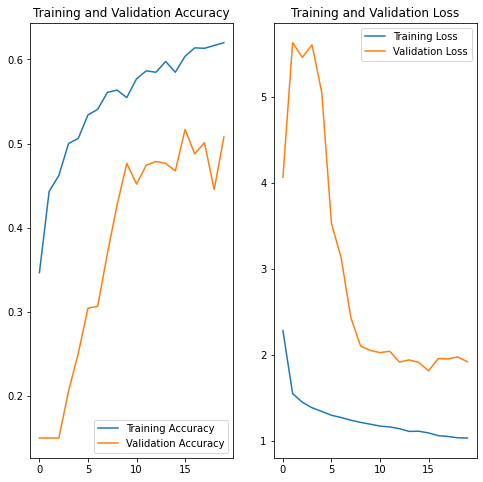

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Todo: Write your findings after the model fit, see if there is an evidence of model overfit or underfit. Do you think there is some improvement now as compared to the previous model run?

Observations :

- The Training accuracy got improved but still the model is not learning well and the accuracy scores are far from each others which is indicating more over-fitting.
- We can observe that this can be caused by unbalanced dataset.

#### **Todo:** Find the distribution of classes in the training dataset.
#### **Context:** Many times real life datasets can have class imbalance, one class can have proportionately higher number of samples compared to the others. Class imbalance can have a detrimental effect on the final model quality. Hence as a sanity check it becomes important to check what is the distribution of classes in the data.

<BarContainer object of 9 artists>

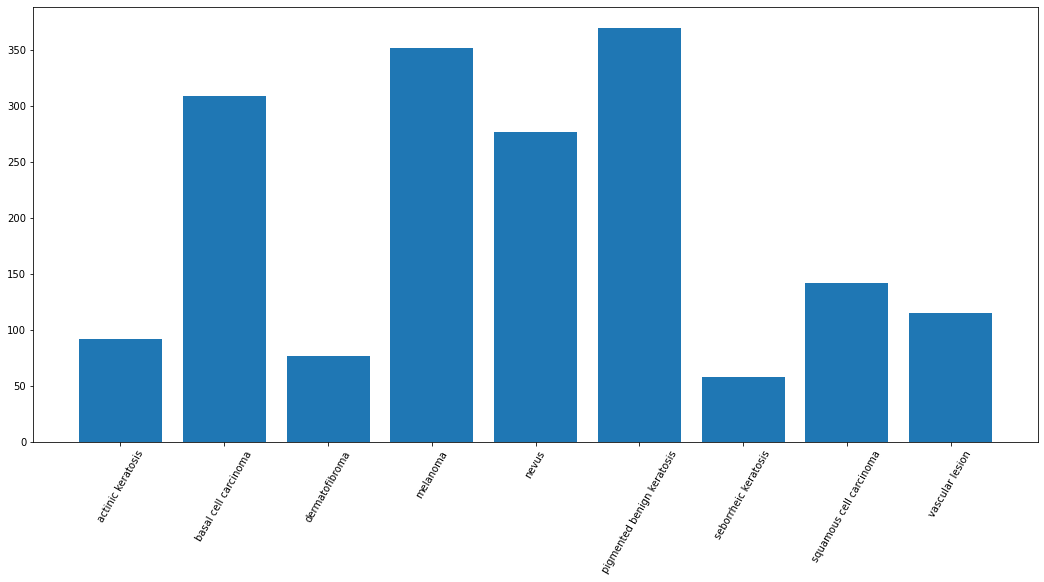

In [ ]:
## Your code goes here.
count = np.zeros(num_classes, dtype=np.int32)
for images, labels in train_ds:
    y, _, c = tf.unique_with_counts(labels)
    count[y.numpy()] += c.numpy()

plt.figure(figsize=(18, 8))
plt.xticks(rotation = 60)
plt.bar(class_names, count)

**Observations:** from the plot above we can observe that the dataset has unbalanced classes

- The classes [seborrheic keratosis, dematofibroma and actinic keratosis] are with the lower samples.
- We observe a domination of samples on the classes [pigmented benign keratosis, melanoma, nevus and basal cell carcinoma]
- This observations confirm the cause of the over-fitting even after the use of data augmentation using keras.

#### **Todo:** Rectify the class imbalance
#### **Context:** You can use a python package known as `Augmentor` (https://augmentor.readthedocs.io/en/master/) to add more samples across all classes so that none of the classes have very few samples.

In [ ]:
# !pip install Augmentor

To use `Augmentor`, the following general procedure is followed:

1. Instantiate a `Pipeline` object pointing to a directory containing your initial image data set.<br>
2. Define a number of operations to perform on this data set using your `Pipeline` object.<br>
3. Execute these operations by calling the `Pipeline’s` `sample()` method.


In [38]:
class_names

['actinic keratosis',
 'basal cell carcinoma',
 'dermatofibroma',
 'melanoma',
 'nevus',
 'pigmented benign keratosis',
 'seborrheic keratosis',
 'squamous cell carcinoma',
 'vascular lesion']

In [48]:
path_to_training_dataset= "Train/" #"To do"
import Augmentor
for i in class_names:
    p = Augmentor.Pipeline(path_to_training_dataset + i)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500) ## We are adding 500 samples per class to make sure that none of the classes are sparse.

Initialised with 114 image(s) found.
Output directory set to Train/actinic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F527067CF10>: 100%


Initialised with 376 image(s) found.
Output directory set to Train/basal cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F50AEF4BAC0>: 100%


Initialised with 95 image(s) found.
Output directory set to Train/dermatofibroma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7


Initialised with 438 image(s) found.
Output directory set to Train/melanoma/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7F50B60AA6D0>: 100


Initialised with 357 image(s) found.
Output directory set to Train/nevus/output.

Processing <PIL.Image.Image image mode=RGB size=1504x1129 at 0x7F51481090A0>: 10


Initialised with 462 image(s) found.
Output directory set to Train/pigmented benign keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F50B604BC10>: 100%


Initialised with 77 image(s) found.
Output directory set to Train/seborrheic keratosis/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1024x768 at 0x


Initialised with 181 image(s) found.
Output directory set to Train/squamous cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F50B6064A00>: 100%


Initialised with 139 image(s) found.
Output directory set to Train/vascular lesion/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F50B61153A0>: 100%


Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.

In [49]:
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

4500


### Lets see the distribution of augmented data after adding new images to the original training data.

In [62]:
path_list_org = [x for x in glob(os.path.join(data_dir_train, '*', '*.jpg'))]
path_list_org

['Train/actinic keratosis/ISIC_0025780.jpg',
 'Train/actinic keratosis/ISIC_0025803.jpg',
 'Train/actinic keratosis/ISIC_0025825.jpg',
 'Train/actinic keratosis/ISIC_0025953.jpg',
 'Train/actinic keratosis/ISIC_0025957.jpg',
 'Train/actinic keratosis/ISIC_0025992.jpg',
 'Train/actinic keratosis/ISIC_0026040.jpg',
 'Train/actinic keratosis/ISIC_0026149.jpg',
 'Train/actinic keratosis/ISIC_0026171.jpg',
 'Train/actinic keratosis/ISIC_0026194.jpg',
 'Train/actinic keratosis/ISIC_0026212.jpg',
 'Train/actinic keratosis/ISIC_0026457.jpg',
 'Train/actinic keratosis/ISIC_0026468.jpg',
 'Train/actinic keratosis/ISIC_0026525.jpg',
 'Train/actinic keratosis/ISIC_0026575.jpg',
 'Train/actinic keratosis/ISIC_0026625.jpg',
 'Train/actinic keratosis/ISIC_0026650.jpg',
 'Train/actinic keratosis/ISIC_0026702.jpg',
 'Train/actinic keratosis/ISIC_0026709.jpg',
 'Train/actinic keratosis/ISIC_0026729.jpg',
 'Train/actinic keratosis/ISIC_0026765.jpg',
 'Train/actinic keratosis/ISIC_0026848.jpg',
 'Train/ac

In [64]:
lesion_list = [os.path.basename(os.path.dirname(y)) for y in path_list_org]# glob(os.path.join(data_dir_train, '*', '*', '*.jpg'))]
lesion_list

['actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic 

In [68]:
dataframe_dict_org = dict(zip(path_list_org, lesion_list))

In [69]:
original_df = pd.DataFrame(list(dataframe_dict_org.items()),columns = ['Path','Label'])

In [70]:
original_df['Label'].value_counts()

pigmented benign keratosis    462
melanoma                      438
basal cell carcinoma          376
nevus                         357
squamous cell carcinoma       181
vascular lesion               139
actinic keratosis             114
dermatofibroma                 95
seborrheic keratosis           77
Name: Label, dtype: int64

In [71]:
path_list_new = [x for x in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
path_list_new

['Train/actinic keratosis/output/actinic keratosis_original_ISIC_0025780.jpg_09a196a5-1b6c-4a0e-8604-5458ff7d515e.jpg',
 'Train/actinic keratosis/output/actinic keratosis_original_ISIC_0025780.jpg_437e16d5-819b-428a-bdb6-b61f7a6eea33.jpg',
 'Train/actinic keratosis/output/actinic keratosis_original_ISIC_0025780.jpg_89df60e5-63c8-40e5-a70a-66f5c8484ed8.jpg',
 'Train/actinic keratosis/output/actinic keratosis_original_ISIC_0025780.jpg_8bec5614-e772-497d-90cd-5d74aa7fe7e1.jpg',
 'Train/actinic keratosis/output/actinic keratosis_original_ISIC_0025803.jpg_59e2ec58-5611-4303-9c3e-45a7ec706e6d.jpg',
 'Train/actinic keratosis/output/actinic keratosis_original_ISIC_0025803.jpg_758a3768-598e-4b3a-8b4c-5b1cc40b3553.jpg',
 'Train/actinic keratosis/output/actinic keratosis_original_ISIC_0025803.jpg_839320d2-e9a4-493d-8de4-2649b0b5e5d6.jpg',
 'Train/actinic keratosis/output/actinic keratosis_original_ISIC_0025803.jpg_9f9a9b0f-3a03-4ab3-af18-fa423bafe1e6.jpg',
 'Train/actinic keratosis/output/actinic

In [74]:
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in path_list_new] #glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
lesion_list_new

['actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic 

In [75]:
dataframe_dict_new = dict(zip(path_list_new, lesion_list_new))

In [76]:
df2 = pd.DataFrame(list(dataframe_dict_new.items()),columns = ['Path','Label'])
df2['Label'].value_counts()

actinic keratosis             500
basal cell carcinoma          500
dermatofibroma                500
melanoma                      500
nevus                         500
pigmented benign keratosis    500
seborrheic keratosis          500
squamous cell carcinoma       500
vascular lesion               500
Name: Label, dtype: int64

In [77]:
new_df = original_df.append(df2)
new_df['Label'].value_counts()

pigmented benign keratosis    962
melanoma                      938
basal cell carcinoma          876
nevus                         857
squamous cell carcinoma       681
vascular lesion               639
actinic keratosis             614
dermatofibroma                595
seborrheic keratosis          577
Name: Label, dtype: int64

So, now we have added 500 images to all the classes to maintain some class balance. We can add more images as we want to improve training process.

<BarContainer object of 9 artists>

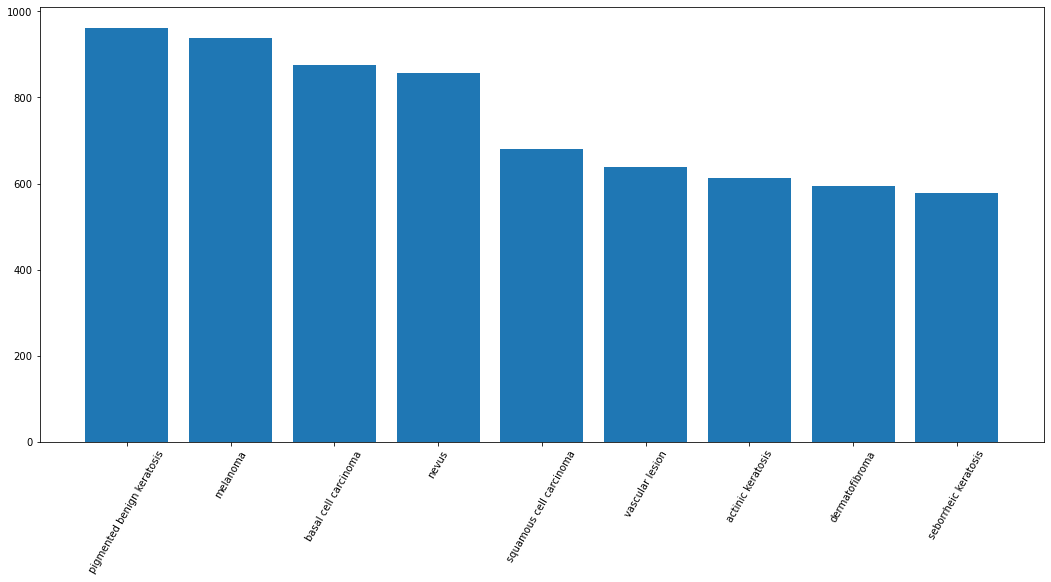

In [133]:
plt.figure(figsize=(18, 8))
plt.xticks(rotation = 60)
plt.bar(new_df['Label'].value_counts().index, new_df['Label'].value_counts())

Observations:
- The Augmentor library handle well the increasing of the unbalanced classes to have a good distribution of the data samples.

#### **Todo**: Train the model on the data created using Augmentor

In [78]:
batch_size = 32
img_height = 180
img_width = 180

#### **Todo:** Create a training dataset

In [97]:
data_dir_train= pathlib.Path('Train/')  #"path to directory with training data + data created using augmentor"
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train,
    seed=123,
    validation_split = 0.2,
    subset = 'training', ## Todo choose the correct parameter value, so that only training data is refered to,,
    image_size=(img_height, img_width),
    batch_size=batch_size)

Found 11239 files belonging to 9 classes.
Using 8992 files for training.


#### **Todo:** Create a validation dataset

In [98]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train,
    seed=123,
    validation_split = 0.2,
    subset = 'validation', ## Todo choose the correct parameter value, so that only validation data is refered to,
    image_size=(img_height, img_width),
    batch_size=batch_size)

Found 11239 files belonging to 9 classes.
Using 2247 files for validation.


#### **Todo:** Create your model (make sure to include normalization)

In [115]:
## your code goes here
model3 = Sequential([
    layers.experimental.preprocessing.Rescaling(1./255,  input_shape=img_shape),
    BatchNormalization(),
    
    Conv2D(16, (3, 3), padding='same', activation='relu'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.25),
    
    Conv2D(32, (3, 3), padding='same', activation='relu'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.25),
    
    Conv2D(64, (3, 3), padding='same', activation='relu'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.25),
    
    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.25),
    Dense(num_classes, activation='softmax'),
])

#### **Todo:** Compile your model (Choose optimizer and loss function appropriately)

In [116]:
## your code goes here
model3.compile(optimizer='sgd',
#               loss='categorical_crossentropy',
              loss = 'sparse_categorical_crossentropy',
              metrics=['accuracy'])

model3.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling_5 (Rescaling)      (None, 180, 180, 3)       0         
_________________________________________________________________
batch_normalization_18 (Batc (None, 180, 180, 3)       12        
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 180, 180, 16)      448       
_________________________________________________________________
batch_normalization_19 (Batc (None, 180, 180, 16)      64        
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 90, 90, 16)        0         
_________________________________________________________________
dropout_14 (Dropout)         (None, 90, 90, 16)        0         
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 90, 90, 32)       

#### **Todo:**  Train your model

In [117]:
epochs = 30
## Your code goes here, use 50 epochs.
history3 = model3.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/30
281/281 [==============================] - 74s 257ms/step - loss: 2.8161 - accuracy: 0.3791 - val_loss: 6.8280 - val_accuracy: 0.1535
Epoch 2/30
281/281 [==============================] - 73s 255ms/step - loss: 0.9724 - accuracy: 0.6550 - val_loss: 1.7811 - val_accuracy: 0.5185
Epoch 3/30
281/281 [==============================] - 76s 265ms/step - loss: 0.6748 - accuracy: 0.7625 - val_loss: 0.9117 - val_accuracy: 0.6907
Epoch 4/30
281/281 [==============================] - 74s 260ms/step - loss: 0.5118 - accuracy: 0.8189 - val_loss: 0.7863 - val_accuracy: 0.7397
Epoch 5/30
281/281 [==============================] - 71s 248ms/step - loss: 0.4065 - accuracy: 0.8537 - val_loss: 0.7497 - val_accuracy: 0.7539
Epoch 6/30
281/281 [==============================] - 73s 255ms/step - loss: 0.3269 - accuracy: 0.8771 - val_loss: 0.5456 - val_accuracy: 0.8180
Epoch 7/30
281/281 [==============================] - 72s 253ms/step - loss: 0.2843 - accuracy: 0.9004 - val_loss: 0.5835 - val_ac

#### **Todo:**  Visualize the model results

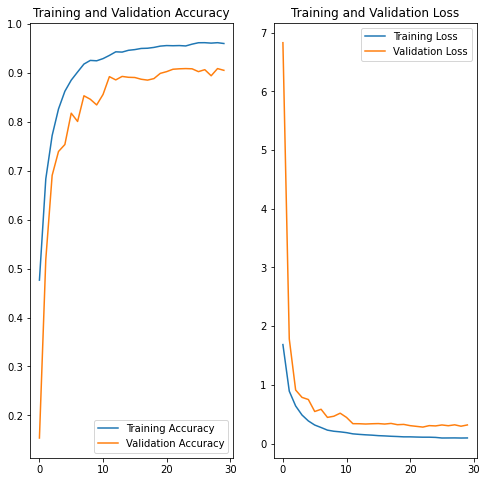

In [118]:
acc = history3.history['accuracy']
val_acc = history3.history['val_accuracy']

loss = history3.history['loss']
val_loss = history3.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### **Todo:**  Analyze your results here. Did you get rid of underfitting/overfitting? Did class rebalance help?



**Observations :**
- The Classes re-balancing by augmentation method helps a lot the model to generalize well with good accuracy scores train accuracy: 0.9601 - val_accuracy: 0.9057
- Reducing dramatically both under-fitting and over-fitting error problems as first step give more idea to play with hyper-parameter tuning to increase the accuracy for both Train and Validation scores or using transfer learning.